In [ ]:
import torch
import torch.nn as nn
import torchvision
import random
import time
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import os
import numpy as np
from torchvision import models
from torchcam.methods import GradCAM
from ConvNeXt.model import ConvNeXt
from torchvision import models, transforms
from torchsummary import summary
from tqdm import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [104]:
# Check cuda is working
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [105]:
model = models.convnext_tiny(weights=True, drop_out_rate=0.2).to(device)

In [106]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [107]:
# Download CIFAR100 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root="C:\\Users\\tony1\\OneDrive\\桌面\\Python\\ConvNeXt\\data", train=True, download=False, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="C:\\Users\\tony1\\OneDrive\\桌面\\Python\\ConvNeXt\\data", train=False, download=False, transform=transform
)

In [108]:
random.seed(42)
train_size = int(0.8 * len(train_dataset))  # 80%
val_size = len(train_dataset) - train_size  # 20%
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

In [109]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [111]:
class ConvNeXtTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        criterion,
        optimizer,
        epochs=20,
        device=None,  # 新增設備參數
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train(self):
        self.model.train()
        start_time = time.time()  # 記錄訓練開始時間
        for epoch in range(self.epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(
                self.train_loader, desc=f"Epoch {epoch + 1}/{self.epochs} Training"
            ):
                inputs = inputs.float().to(self.device)  # 確保是 float
                labels = labels.to(self.device)
                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)  # y-yhat

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Track loss
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            # Calculate average loss and accuracy
            avg_loss = running_loss / len(self.train_loader)
            accuracy = 100 * correct / total

            # Store the loss and accuracy
            self.train_losses.append(avg_loss)
            self.train_accuracies.append(accuracy)

            print(
                f"Epoch [{epoch + 1}/{self.epochs}], Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%"
            )

            # Validation after each epoch
            val_loss, val_accuracy = self.validate()
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

            print(
                f"Epoch [{epoch + 1}/{self.epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%"
            )

        end_time = time.time()  # 記錄訓練結束時間
        total_time = end_time - start_time  # 計算總訓練時間
        print(f"Total Training Time: {total_time:.2f} seconds")

    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(self.val_loader, desc="Validating"):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(self.val_loader)
        accuracy = 100 * correct / total
        return avg_val_loss, accuracy

    def plot_graphs(self):
        epochs = range(1, self.epochs + 1)

        # Plot training & validation loss values
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label="Training Loss")
        plt.plot(epochs, self.val_losses, label="Validation Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label="Training Accuracy")
        plt.plot(epochs, self.val_accuracies, label="Validation Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy (%)")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(self.test_loader, desc="Testing"):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")

In [112]:
# Initialize the trainer
trainer = ConvNeXtTrainer(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=10,  # Adjusted epochs to see the trends better
    device=device,
)

In [113]:
trainer.train()

Epoch 1/10 Training: 100%|██████████| 313/313 [03:36<00:00,  1.44it/s]


Epoch [1/10], Training Loss: 0.4617, Training Accuracy: 87.75%


Validating: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]


Epoch [1/10], Validation Loss: 0.1014, Validation Accuracy: 96.54%


Epoch 2/10 Training: 100%|██████████| 313/313 [03:39<00:00,  1.42it/s]


Epoch [2/10], Training Loss: 0.0497, Training Accuracy: 98.42%


Validating: 100%|██████████| 79/79 [00:15<00:00,  5.15it/s]


Epoch [2/10], Validation Loss: 0.0758, Validation Accuracy: 97.45%


Epoch 3/10 Training: 100%|██████████| 313/313 [03:38<00:00,  1.43it/s]


Epoch [3/10], Training Loss: 0.0155, Training Accuracy: 99.53%


Validating: 100%|██████████| 79/79 [00:15<00:00,  5.12it/s]


Epoch [3/10], Validation Loss: 0.0994, Validation Accuracy: 97.21%


Epoch 4/10 Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch [4/10], Training Loss: 0.0135, Training Accuracy: 99.55%


Validating: 100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Epoch [4/10], Validation Loss: 0.1020, Validation Accuracy: 97.09%


Epoch 5/10 Training: 100%|██████████| 313/313 [03:56<00:00,  1.32it/s]


Epoch [5/10], Training Loss: 0.0138, Training Accuracy: 99.54%


Validating: 100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Epoch [5/10], Validation Loss: 0.1294, Validation Accuracy: 96.60%


Epoch 6/10 Training: 100%|██████████| 313/313 [03:56<00:00,  1.32it/s]


Epoch [6/10], Training Loss: 0.0193, Training Accuracy: 99.40%


Validating: 100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


Epoch [6/10], Validation Loss: 0.1074, Validation Accuracy: 97.07%


Epoch 7/10 Training: 100%|██████████| 313/313 [03:56<00:00,  1.32it/s]


Epoch [7/10], Training Loss: 0.0062, Training Accuracy: 99.78%


Validating: 100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Epoch [7/10], Validation Loss: 0.1241, Validation Accuracy: 97.06%


Epoch 8/10 Training: 100%|██████████| 313/313 [03:56<00:00,  1.32it/s]


Epoch [8/10], Training Loss: 0.0099, Training Accuracy: 99.65%


Validating: 100%|██████████| 79/79 [00:15<00:00,  5.23it/s]


Epoch [8/10], Validation Loss: 0.1386, Validation Accuracy: 96.73%


Epoch 9/10 Training: 100%|██████████| 313/313 [03:39<00:00,  1.43it/s]


Epoch [9/10], Training Loss: 0.0092, Training Accuracy: 99.69%


Validating: 100%|██████████| 79/79 [00:15<00:00,  5.18it/s]


Epoch [9/10], Validation Loss: 0.1035, Validation Accuracy: 97.42%


Epoch 10/10 Training: 100%|██████████| 313/313 [03:47<00:00,  1.38it/s]


Epoch [10/10], Training Loss: 0.0076, Training Accuracy: 99.74%


Validating: 100%|██████████| 79/79 [00:15<00:00,  4.94it/s]

Epoch [10/10], Validation Loss: 0.1289, Validation Accuracy: 97.14%
Total Training Time: 2453.03 seconds


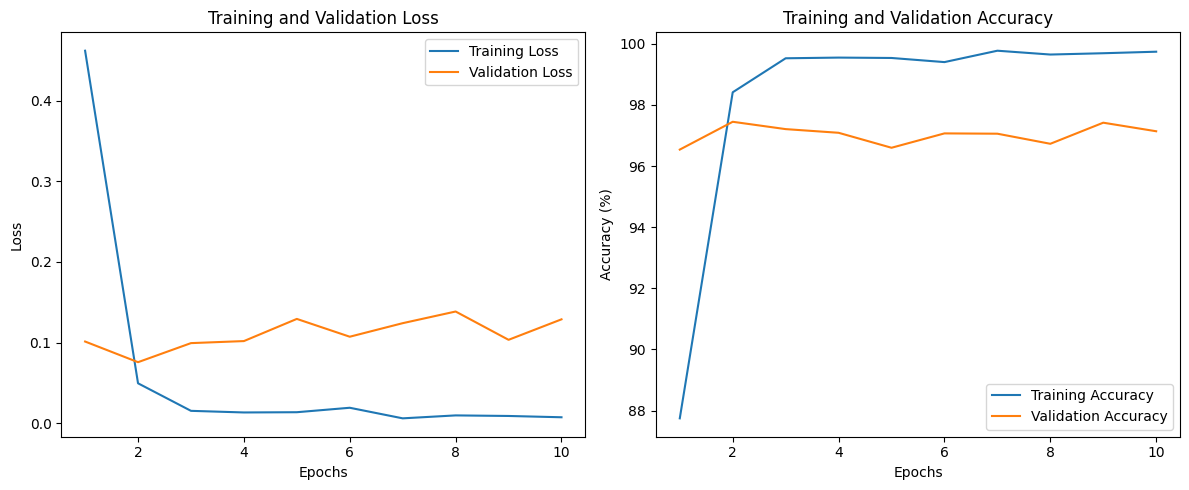

In [116]:
trainer.plot_graphs()

In [117]:
trainer.test()

Testing: 100%|██████████| 79/79 [00:16<00:00,  4.90it/s]

Test Accuracy: 96.67%
